## Multi-GPU Training Tutorial

For this tutorial we will explore multi-GPU training. We will show you a basic structure for using the `data_parallel_model` to quickly process a subset of the ImageNet database along the same design as the [Resnet-50 model](https://arxiv.org/abs/1512.03385). We will also get a chance to look under the hood at a few of Caffe2's C++ operators that efficiently handle your image pipeline, making loading images and training faster and helping you use multiple GPUs without a bunch of extra coding on your part.

### About the Dataset

A commonly used dataset for benchmarking image recognition technologies is [ImageNet](http://image-net.org/). It is huge. It has images that cover the gamut, and they're categorized by labels so that you can create image subsets of animals, plants, fungi, people, objects, you name it. It's the focus of yearly competitions and this is where deep learning and convolutional neural networks (CNN) really made its name. During the 2012 ImageNet Large-Scale Visual Recognition Challenge a CNN demonstrated accuracy more than 10% beyond the next competing method. Going from around 75% accuracy to around 85% accuracy when every year the gains were only a percent or two is a significant accomplishment. 

![imagenet montage](images/imagenet-montage.jpg)

So let's play with ImageNet and train our own model on a bunch of GPUs! You're going to need a lot space to host the 14 million images in ImageNet. How much disk space do you have? You should clear up about 300GB of space... on SSD. Spinning discs are so 2000. How much time do you have? With two GPUs maybe we'll be done in just under a week. Ready?

![one does not simply train imagenet in a minute](images/imagenet-meme.jpg)

That's way too much space and way too long for a tutorial! If you happened to have that much space and 128 GPUs on the latest NVIDIA P-100s then you're super awesome and you can replicate our recent results shown below. **[update with recent chart]**

![performance chart](images/perfchart.png)

Instead of tons of GPUs and the full set of data, we're going to do this cooking show style. We're going to use a small batch images to train on, and show how you can scale that up. We chose a small slice of ImageNet: a set of 640 cars and 640 boats for our training set. We have 48 cars and 48 boats for our test set. This makes our database of images around 130 MB.

The code below will download a small database of boats and cars images and their labels for you if it doesn't already exist. The images were pulled from ImageNet and added to a `lmdb` format database. You can download it directly [here](https://s3.amazonaws.com/caffe2/databases/resnet_trainer.zip) unzip it, and change the folder locations to an NFS if that better suits your situation. You can also swap out the database with your own as long as it is in lmdb and you change the `train_data_count` and `test_data_count` variables below.

In [2]:
from caffe2.python import core, workspace, cnn, net_drawer
from caffe2.python import data_parallel_model as dpm
from caffe2.python.models import resnet

import numpy as np
import time
import os
from IPython import display
    
workspace.GlobalInit(['caffe2', '--caffe2_log_level=2'])

# This section checks if you have the training and testing databases
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'resnet_trainer')

# Train/test data
train_data_db = os.path.join(data_folder, "imagenet_cars_boats_train")
train_data_db_type = "lmdb"
# actually 640 cars and 640 boats = 1280
train_data_count = 1280
test_data_db = os.path.join(data_folder, "imagenet_cars_boats_val")
test_data_db_type = "lmdb"
# actually 48 cars and 48 boats = 96
test_data_count = 96

# Get the dataset if it is missing
def DownloadDataset(url, path):
    import requests, zipfile, StringIO
    print "Downloading... ", url, " to ", path
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)

# Make the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
# See if you already have to db, and if not, download it
if not os.path.exists(train_data_db):
    DownloadDataset("https://s3.amazonaws.com/caffe2/databases/resnet_trainer.zip", data_folder) 

### Configure the Training

Below you can tinker with some of the settings for how the model will be created. One obvious setting to try is the `gpus`. By removing one or adding one you're directly impacting the amount of time it will take to run even on this small dataset.

`batch_per_device` is the number of images processed at a time on each GPU. Using the default of 32 for 2 GPUs will equate to 32 images on each GPU for a total of 20 per batch, so we'll go through the whole database and complete an epoch in 20 batches. This is something you would want to adjust if you're sharing the GPU or otherwise want to adjust how much memory this training run is going to take up. You can see in the line below it being set to `32` we're adjusting the total_batch_size based on the number of GPUs.

`base_learning_rate` and `weight_decay` will both influence training and can be interesting to change and witness the impact on accuracy or confidence is the results that are shown in the last section of this tutorial.

In [3]:
# Configure how you want to train the model and with how many GPUs
# This is set to use two GPUs in a single machine, but if you have more GPUs, extend the array [0, 1, 2, n]
gpus = [0, 1]

# Batch size of 32 sums up to roughly 5GB of memory per device
batch_per_device = 32
total_batch_size = batch_per_device * len(gpus)

# This model discriminates between two labels: car or boat
num_labels = 2

# Initial learning rate (scale with total batch size)
base_learning_rate = 0.0004 * total_batch_size

# Weight decay (L2 regularization)
weight_decay = 1e-4

### Run the Training

Below is the code that is needed to train this model across multiple GPUs. You see that it is generally not that long, nor is it that complicated. A lot of the interactions are handled by functions and we'll go over those later. Of course we'll have to declare all of those functions before running the code below, but it will be helpful to see the overall structure first, and then dig into the functions as they're called.


```
train_model = create_train_model()
test_model = create_test_model()

# Usually you would want to run a lot more epochs to increase your model's accuracy
num_epochs = 5
for epoch in range(num_epochs):
    num_iters = int(train_data_count / total_batch_size)
    for iter in range(num_iters):
        t1 = time.time()
        workspace.RunNet(train_model.net.Proto().name)
        t2 = time.time()
        dt = t2 - t1

        print((
            "Finished iteration {:>" + str(len(str(num_iters))) + "}/{}" +
            " (epoch {:>" + str(len(str(num_epochs))) + "}/{})" + 
            " ({:.2f} images/sec)").
            format(iter+1, num_iters, epoch+1, num_epochs, total_batch_size/dt))

        train_accuracy = accuracy(train_model)
    
    # Run the test model
    test_accuracies = []
    for _ in range(test_data_count / total_batch_size):
        workspace.RunNet(test_model.net.Proto().name)
        test_accuracies.append(accuracy(test_model))
    test_accuracy = np.average(test_accuracies)

    print(
        "Train accuracy: {:.3f}, test accuracy: {:.3f}".
        format(train_accuracy, test_accuracy))
    
    display_images_and_confidence()

```

## Image Transformations

Since images that are found in the wild can be wildly different sizes, aspect ratios, and orientations we can and should train on as much variety as we can. ImageNet is no exception here. The average resolution is 496x387, and as interesting as that factoid might be, the bottle line is that you have a lot of variation. 

As the training images are ingested we would want to conform them to a standard size. The most direct process of doing so could follow a simple ingest where you transform the image to 256x256. We talked about the drawbacks of doing this in [Image Pre-Processing](Image_Pre-Processing_Pipeline.ipynb). Therefore for more accurate results, we should probably rescale, then crop. Even this approach with cropping has the drawbacks of losing some info from the original photo. What get chopped off doesn't make into the training data. If you ran the pre-processing tutorial on the image of the astronauts you will recall that some of the astronauts didn't make the cut. Where'd they go? Wash-out lane? Planet of the Apes? If your model was to detect people, then those lost astronauts would not be getting due credit when you run inference or face detection later using the model.

### Introducing... the ImageInput Operator

What could be seen as a loss turns into an opportunity. You can crop randomly around the image to create many deriviates of the original image, boosting your training data set, thereby adding robustness to the model. What if the image only has half a car or the front of a boat? You still want your model to be able to detect it! In the image below only the front a boat is shown and the model shows a 50% confidence in detection.

![boat image](images/tutorial-boat.png)

Caffe2 has a solution for this in its [`ImageInput` operator](https://github.com/caffe2/caffe2/blob/master/caffe2/image/image_input_op.h), a C++ image manipulation op that's used under the hood of several of the Caffe2 Python APIs.

In the code block below we're going to pass several arguments to the `ImageInput` op and it is going to do a bunch of stuff under the hood that will improve the model for you.

* mean: remove info that's common in most images
* std: used to create a randomization for both cropping and mirroring
* scale: downres each image so that its shortest side matches this base resolution
* crop: the image size we want every image to be (using random crops from the scaled down image)
* mirror: randomly mirror the images so we can train on both representations

The [`StopGradient` operator](https://caffe2.ai/docs/operators-catalogue.html#stopgradient) does no numerical computation.

In [13]:
# Image input operator that loads data from reader and
# applies certain transformations to the images.
def add_image_input_fn(reader):
    def add_image_input(model):
        # utilize the ImageInput operator to prep the images
        data, label = model.ImageInput(
            reader,
            ["data", "label"],
            batch_size=batch_per_device,
            # mean: to remove color values that are common
            mean=128.,
            # std is going to be modified randomly to influence the mean subtraction
            std=128.,
            # scale to rescale each image to a common size
            scale=256,
            # crop to the square each image to exact dimensions
            crop=224,
            # mirroring of the images will occur randomly
            mirror=1
        )
        data = model.StopGradient(data, data)
    return add_image_input


def add_momentum_sgd_update(train_model, lr):
    for param in train_model.GetParams():
        param_grad = train_model.param_to_grad[param]
        param_momentum = train_model.param_init_net.ConstantFill(
            [param], param + '_momentum', value=0.0
        )

        # Update param_grad and param_momentum in place
        train_model.net.MomentumSGDUpdate(
            [param_grad, param_momentum, lr, param],
            [param_grad, param_momentum, param],
            # almost 100% but with room to grow
            momentum=0.9,
            # a defenseman for the Montreal Canadiens, true
            nesterov=1,
        )

        
def create_resnet50_model_ops(model, loss_scale):
    [softmax, loss] = resnet.create_resnet50(
        model,
        "data",
        num_input_channels=3,
        num_labels=num_labels,
        label="label",
    )
    prefix = model.net.Proto().name
    loss = model.Scale(loss, prefix + "_loss", scale=loss_scale)
    model.Accuracy([softmax, "label"], prefix + "_accuracy")
    return [loss]


def add_parameter_update_ops(model):
    model.AddWeightDecay(weight_decay)
    stepsize = int(10 * train_data_count / total_batch_size)
    iter = model.Iter("iter")
    lr = model.net.LearningRate(
        [iter],
        "lr",
        base_lr=base_learning_rate,
        policy="step",
        stepsize=stepsize,
        gamma=0.1,
    )
    add_momentum_sgd_update(model, lr)
    
    
def create_train_model():
    # Use the model helper to create a CNN for us
    train_model = cnn.CNNModelHelper(
        order="NCHW",
        name="train",
    )

    # This training data reader is shared between all GPUs.
    # When reading data, the trainer runs ImageInputOp for each GPU to retrieve their own unique batch of training data.
    # CreateDB comes from model_helper.py
    reader = train_model.CreateDB(
        "train_reader",
        db=train_data_db,
        db_type=train_data_db_type,
    )


    # Create parallelized model
    dpm.Parallelize_GPU(
        train_model,
        input_builder_fun=add_image_input_fn(reader),
        forward_pass_builder_fun=create_resnet50_model_ops,
        param_update_builder_fun=add_parameter_update_ops,
        devices=gpus,
        optimize_gradient_memory=True,
    )


    workspace.RunNetOnce(train_model.param_init_net)
    workspace.CreateNet(train_model.net)
    return train_model


def accuracy(model):
    accuracy = []
    prefix = model.net.Proto().name
    for device in model._devices:
        accuracy.append(
            np.asscalar(workspace.FetchBlob("gpu_{}/{}_accuracy".format(device, prefix))))
    return np.average(accuracy)

# Test model

After every epoch of training, we like to run some validation data through our model to see how it performs.

Like training, this is another net, with its own data reader. Unlike training, this net does not perform backpropagation.  It only does a forward pass and compares the output of the network with the label of the validation data.

In [5]:
def create_test_model():
    test_model = cnn.CNNModelHelper(
        order="NCHW",
        name="test",
    )

    reader = test_model.CreateDB(
        "test_reader",
        db=test_data_db,
        db_type=test_data_db_type,
    )

    # Validation is parallelized across devices as well
    dpm.Parallelize_GPU(
        test_model,
        input_builder_fun=add_image_input_fn(reader),
        forward_pass_builder_fun=create_resnet50_model_ops,
        param_update_builder_fun=None,
        devices=gpus,
    )

    workspace.RunNetOnce(test_model.param_init_net)
    workspace.CreateNet(test_model.net)
    
    return test_model

# Code to display intermediary test results

So we can take a look at how the network performs visually.

In [6]:
%matplotlib inline
from caffe2.python import visualize
from matplotlib import pyplot as plt

def display_images_and_confidence():
    images = []
    confidences = []
    n = 16
    data = workspace.FetchBlob("gpu_0/data")
    label = workspace.FetchBlob("gpu_0/label")
    softmax = workspace.FetchBlob("gpu_0/softmax")
    for arr in zip(data[0:n], label[0:n], softmax[0:n]):
        # CHW to HWC, normalize to [0.0, 1.0], and BGR to RGB
        bgr = (arr[0].swapaxes(0, 1).swapaxes(1, 2) + 1.0) / 2.0
        rgb = bgr[...,::-1]
        images.append(rgb)
        confidences.append(arr[2][arr[1]])

    # Create grid for images
    fig, rows = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    plt.tight_layout(h_pad=2)

    # Display images and the models confidence in their label
    items = zip([ax for cols in rows for ax in cols], images, confidences)
    for (ax, image, confidence) in items:
        ax.imshow(image)
        color = 'green' if confidence >= 0.5 else 'red'
        ax.set_title("{:.1f}%".format(confidence * 100.0), color=color)

    plt.show()

Finished iteration  1/20 (epoch 1/1) (73.44 images/sec)
Finished iteration  2/20 (epoch 1/1) (184.38 images/sec)
Finished iteration  3/20 (epoch 1/1) (183.15 images/sec)
Finished iteration  4/20 (epoch 1/1) (188.27 images/sec)
Finished iteration  5/20 (epoch 1/1) (189.04 images/sec)
Finished iteration  6/20 (epoch 1/1) (188.72 images/sec)
Finished iteration  7/20 (epoch 1/1) (184.43 images/sec)
Finished iteration  8/20 (epoch 1/1) (202.90 images/sec)
Finished iteration  9/20 (epoch 1/1) (198.50 images/sec)
Finished iteration 10/20 (epoch 1/1) (185.89 images/sec)
Finished iteration 11/20 (epoch 1/1) (185.28 images/sec)
Finished iteration 12/20 (epoch 1/1) (187.88 images/sec)
Finished iteration 13/20 (epoch 1/1) (186.21 images/sec)
Finished iteration 14/20 (epoch 1/1) (201.01 images/sec)
Finished iteration 15/20 (epoch 1/1) (189.30 images/sec)
Finished iteration 16/20 (epoch 1/1) (200.42 images/sec)
Finished iteration 17/20 (epoch 1/1) (201.82 images/sec)
Finished iteration 18/20 (epoch 

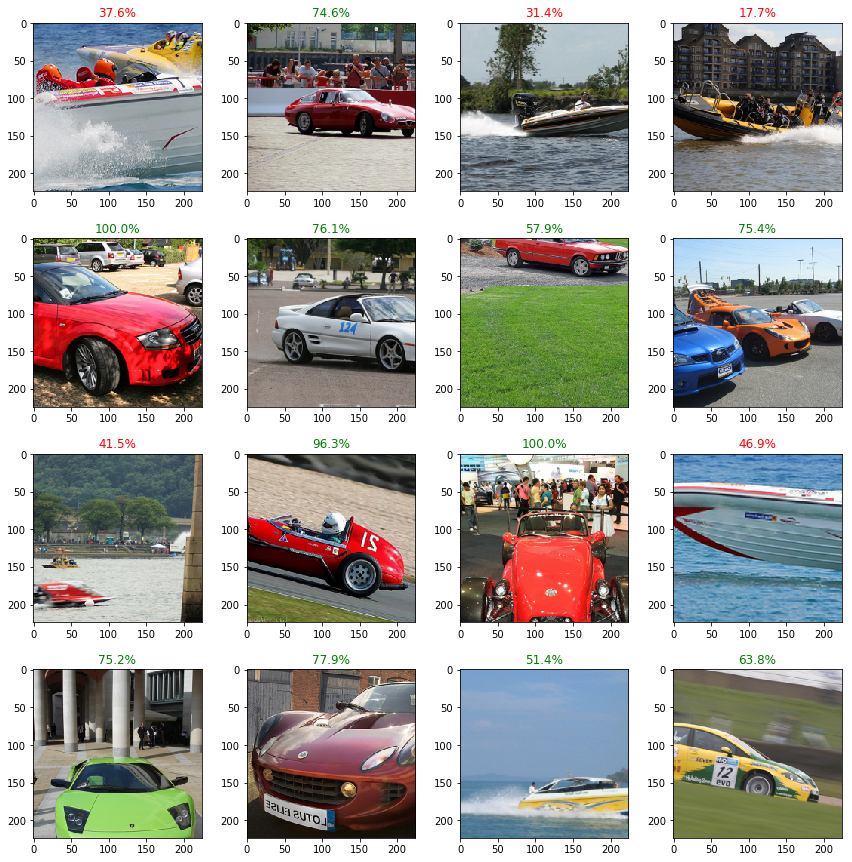

In [12]:
# Initialize the training model and the test model
# A few major steps are here when you create_train_model and create_test_model:
# 1) use CNNModelHelper to create CNN
# 2) create a database reader to pull the images
# 3) create the parallelized model
train_model = create_train_model()
test_model = create_test_model()

# Start looping through epochs where we run the batches of images to cover the entire dataset
# Usually you would want to run a lot more epochs to increase your model's accuracy
num_epochs = 1
for epoch in range(num_epochs):
    # Split up the images evenly: total images / batch size
    num_iters = int(train_data_count / total_batch_size)
    for iter in range(num_iters):
        # Stopwatch start!
        t1 = time.time()
        # Run this iteration!
        workspace.RunNet(train_model.net.Proto().name)
        t2 = time.time()
        # Stopwatch stopped! How'd we do?
        dt = t2 - t1

        print((
            "Finished iteration {:>" + str(len(str(num_iters))) + "}/{}" +
            " (epoch {:>" + str(len(str(num_epochs))) + "}/{})" + 
            " ({:.2f} images/sec)").
            format(iter+1, num_iters, epoch+1, num_epochs, total_batch_size/dt))

        train_accuracy = accuracy(train_model)
    
    # Run the test model and assess accuracy
    test_accuracies = []
    for _ in range(test_data_count / total_batch_size):
        workspace.RunNet(test_model.net.Proto().name)
        test_accuracies.append(accuracy(test_model))
    test_accuracy = np.average(test_accuracies)

    print(
        "Train accuracy: {:.3f}, test accuracy: {:.3f}".
        format(train_accuracy, test_accuracy))
    
    # Output images with confidence scores as the caption
    display_images_and_confidence()


In [11]:
print(str(train_model.param_init_net.Proto())[:1000] + '\n...')

name: "train_init_2"
op {
  output: "train_reader"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "lmdb"
  }
  arg {
    name: "db"
    s: "/home/aaron/caffe2_notebooks/tutorial_data/resnet_trainer/imagenet_cars_boats_train"
  }
}
op {
  output: "gpu_0/conv1_w"
  name: ""
  type: "MSRAFill"
  arg {
    name: "shape"
    ints: 64
    ints: 3
    ints: 7
    ints: 7
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  output: "gpu_0/conv1_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 64
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  output: "gpu_0/conv1_spatbn_relu_s"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 64
  }
  arg {
    name: "value"
    f: 1.0
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  output: "gpu_0/conv1_spatbn_relu_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 64
  }
  arg {
    name: "value"
    f: 0.0

If you enjoyed this tutorial and would like to see it in action in a different way, check Caffe2's Python examples to try a [script version](https://github.com/caffe2/caffe2/blob/master/caffe2/python/examples/resnet50_trainer.py) of this multi-GPU trainer.

### TO DO:

* StopGradient op description - why are we using it here?
* Document each function 
* Explore the layers
* Print out intermediates/activations
* Make some interactions between epochs? Change params?
* Charts! Where my logs at?